# Assignment 3.1

Firstly, we load numerical and plotting libraries:

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

It is also convenient to immediately define some important units and parameters:

In [6]:
# Astronomical units
AU    = 1.0             # distance unit
YR    = 1.0             # time unit
MSUN  = 1.0             # mass unit
G     = 4.0 * math.pi**2  # AU^3 / (MSUN * YR^2)

## Velocity-Verlet method

The acceleration of the $j$-th planet is
\begin{equation}
\mathbf{a}_i \;=\; -G\sum_{j\neq i} m_j \,\frac{\mathbf{r}_i-\mathbf{r}_j}{\|\mathbf{r}_i-\mathbf{r}_j\|^3}.
\end{equation}

According to the **Velocity–Verlet** method, the updates of the positions and velocities of the planets are:
\begin{align}
\mathbf r_{n+1} &= \mathbf r_n + \Delta t\,\mathbf v_n + \tfrac12\Delta t^2\,\mathbf a_n,\\
\mathbf v_{n+1} &= \mathbf v_n + \tfrac12\Delta t\,(\mathbf a_n+\mathbf a_{n+1}),
\end{align}
with $\mathbf a_{n+1} = \mathbf a(\mathbf r_{n+1})$ (where $\mathbf r_{n+1}$ collects the positions of all the planets at the time step $n+1$).

> Notice that we first have to compute $\mathbf r_{n+1}$, then compute $\mathbf a_{n+1}$, and then the velocity $\mathbf v_{n+1}$!

A sample of implementation is the following:

In [ ]:
# We first compute the acceleration array of the mass we are interested into, given the positions of the all the N bodies:

def accelerations(r, m, eps=0.0):
    """
    Compute gravitational accelerations for all bodies (2D).

    
    
    Parameters
    ----------
    r   : array, shape (N, 2)
          Positions of N bodies in AU.
    m   : array, shape (N,)
          Masses in MSUN (solar masses).
    eps : float
          (Optional) softening length in AU (namely, it changes the denominator from r^2 to r^2 + eps^2, which can be helpful to avoid singularities/spikes). Set eps=0.0 for true 1/r^2 gravity.

    
    
    Returns
    -------
    a   : array, shape (N, 2)
          Accelerations (AU / YR^2).
    """


    N = r.shape[0]
    a = np.zeros_like(r)  # (N,2), will store the acceleration for each body i

    # Loop over target body i; accumulate contributions from all j != i.
    # Complexity: O(N^2) operations.
    for i in range(N):
        # Vector from each j to i: r_i - r_j for all j (shape (N,2))
        diff = r[i] - r

        # Squared distances |r_i - r_j|^2 for all j, plus eps^2 for optional regularisation
        # shape (N,)
        dist2 = np.sum(diff**2, axis=1) + eps**2

        # Avoid self-interaction singularity at j = i:
        # Set dist2[i] to a safe non-zero value, then explicitly zero its contribution below.
        dist2[i] = 1.0

        # Compute 1 / |r_i - r_j|^3 for all j (with regularisation if eps>0)
        # (r^2)^{-3/2} = r^{-3}
        invr3 = dist2**(-1.5)

        # Zero-out the self term so body i does not accelerate itself.
        invr3[i] = 0.0

        # Pairwise acceleration sum:
        # a_i = -G * sum_j m_j * (r_i - r_j) / |r_i - r_j|^3
        # Recall:
        #   m[:,None]      -> shape (N,1)
        #   diff           -> shape (N,2)
        #   invr3[:,None]  -> shape (N,1)
        #   product        -> shape (N,2), sum over j -> (2,)
        a[i] = -G * (m[:, None] * diff * invr3[:, None]).sum(axis=0)

    return a

# We compute the velocity-Verlet step:

def step_velocity_verlet(r, v, m, dt, eps=0.0):
    """
    One velocity–Verlet step


    Updates
    -------
    r_{n+1} = r_n + dt * v_n + 0.5 * dt^2 * a_n
    v_{n+1} = v_n + 0.5 * dt * (a_n + a_{n+1})

    """
    a = accelerations(r, m, eps=eps)
    r_new = r + dt * v + 0.5 * dt * dt * a
    a_new = accelerations(r_new, m, eps=eps)
    v_new = v + 0.5 * dt * (a + a_new)

    return r_new, v_new

# Finally, we can find the trajectory:

def integrate_nbody(r0, v0, m, dt, tmax, eps=0.0, record_every=1):
    """
    Integrate the N-body system with velocity–Verlet, optionally down-sampling.

    Parameters
    ----------
    r0, v0 : arrays, shapes (N,2) and (N,2)
             Initial positions (AU) and velocities (AU/YR).
    m      : array, shape (N,)
             Masses in MSUN.
    dt     : float
             Timestep in years (YR).
    tmax   : float
             Final time in years.
    eps    : float
             Regularisation length in AU (use 0.0 for planets).
    record_every : int
             Store every k-th step to control memory usage (k >= 1).
             In our case, setting it to 1 is fine! But for more bodies it may be increased.

    Returns
    -------
    dict with keys:
      "t"   : (T,)       sample times
      "r"   : (T, N, 2)  positions
      "v"   : (T, N, 2)  velocities
      "m"   : (N,)       masses 
      "dt", "tmax", "eps"
    """
    # Ensure contiguous float arrays (avoid integer dtypes sneaking in)
    r = np.array(r0, dtype=float)
    v = np.array(v0, dtype=float)
    m = np.array(m,  dtype=float)

    # Number of integrator steps and which ones we will keep
    Nsteps = int(np.ceil(tmax / dt)) + 1
    keep = np.arange(0, Nsteps, record_every)

    # Pre-allocate output arrays (more efficient than appending)
    T = np.zeros(len(keep))
    R = np.zeros((len(keep),) + r.shape)  # (len(keep), N, 2)
    V = np.zeros((len(keep),) + v.shape)  # (len(keep), N, 2)

    k = 0
    for n in range(Nsteps):
        # Save current state if this step is selected
        if n % record_every == 0:
            T[k] = n * dt
            R[k] = r
            V[k] = v
            k += 1

        # Advance one velocity-Verlet step
        r, v = step_velocity_verlet(r, v, m, dt, eps=eps)

    return {"t": T, "r": R, "v": V, "m": m, "dt": dt, "tmax": tmax, "eps": eps}


## Sun-Earth-Jupiter system

For this three-body system, we introduce the following parameters:

In [8]:
m_sun   = 1.0
m_earth = 3.003e-6
m_jup   = 9.543e-4
m = np.array([m_sun, m_earth, m_jup])

r0 = np.array([
    [0.0, 0.0],   # Sun
    [1.0, 0.0],   # Earth
    [0.0, 5.2],   # Jupiter
], dtype=float)

v0 = np.array([
    [0.0, 0.0],                 # Sun
    [0.0, 2.0*math.pi],         # Earth ~ 1 yr
    [-2.755, 0.0],              # Jupiter ~ 11.86 yr (approx)
], dtype=float)


Hence, we can compute the trajectory by calling the velocity-Verlet method defined above, and plot them:

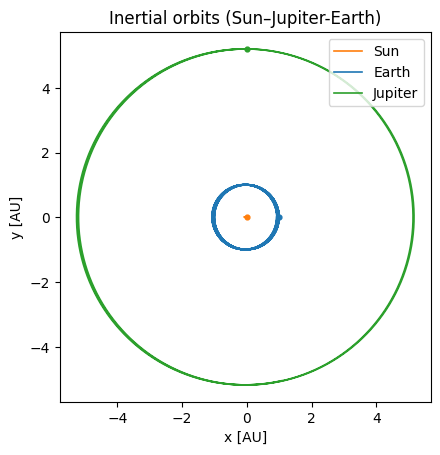

In [9]:
dt, tmax = 1e-3, 30.0  # years
traj = integrate_nbody(r0, v0, m, dt, tmax, eps=0.0, record_every=10)

labels = ["Sun", "Earth", "Jupiter"]
colors = ["tab:orange", "tab:blue", "tab:green"]

def plot_orbits(r_series, title):
    plt.figure()
    for i in range(r_series.shape[1]):
        ri = r_series[:,i,:]
        plt.plot(ri[:,0], ri[:,1], lw=1.2, label=labels[i], color=colors[i])
        plt.scatter([ri[0,0]], [ri[0,1]], s=12, color=colors[i])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x [AU]"); plt.ylabel("y [AU]")
    plt.title(title); plt.legend(); plt.show()

R_inertial = traj["r"]

plot_orbits(R_inertial, "Inertial orbits (Sun–Jupiter-Earth)")

## Orbits with a 'heavier' Jupiter: why ellipses break in inertial plots

We wish to re-reun the code with a heavier mass for Jupyter.
It is convenient to define a function that does the re-run automatically:

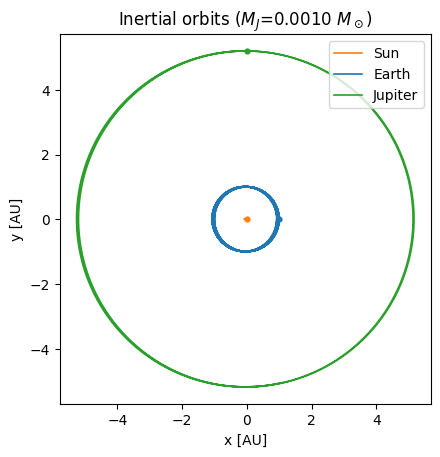

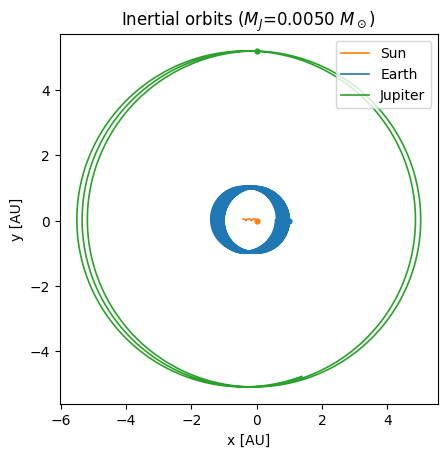

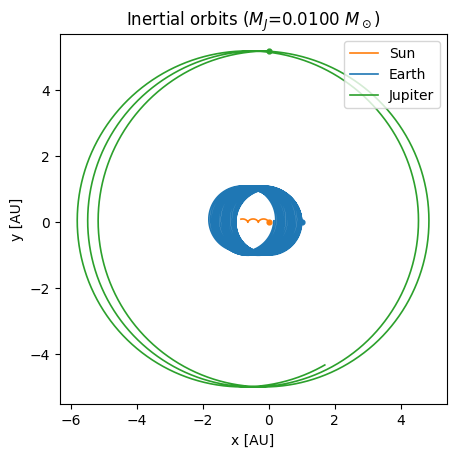

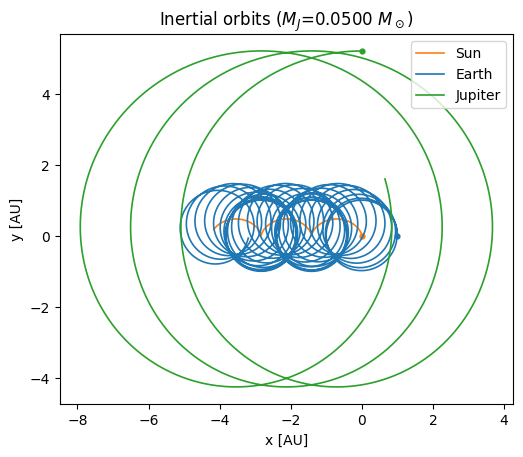

In [14]:
def rerun_with_mj(mj, dt=1e-3, tmax=30.0):
    m_sw = np.array([m_sun, m_earth, mj], dtype=float)
    traj_sw = integrate_nbody(r0, v0, m_sw, dt, tmax, eps=0.0, record_every=10)
    R_in = traj_sw["r"]
    plot_orbits(R_in, f"Inertial orbits ($M_J$={mj:.4f} $M_\odot$)")
    return traj_sw

_ = rerun_with_mj(9.543e-4)  # baseline Jupiter

# Try larger toy values to exaggerate the effect:

_ = rerun_with_mj(0.005)
_ = rerun_with_mj(0.01)
_ = rerun_with_mj(0.05)